# Building a Vehicle Detection Pipeline using HOG Feaures

#### Kevin Wu, Udacity Self Driving Car Nanodegree Program, Term 1

In this notebook I walk through how I trained a linear SVM to detect images of cars and how I built an image processing pipeline to detect vehicles from videos taken on the road. 

### Histogram of Oriented Gradients (HOG)

I use the sklearn's `hog` function to extract a histogram of oriented gradients from an image.
The parameters used for this feature extraction step include:
- pixels per cell: the n x n cell size over which each gradient histogram is computed
- cells per block: number of cells over which gradients are normalized
- orient: The number of orientation bins in the histogram of gradients

In [1]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


Let's load in the training images and visualize some examples of HOG features. 

Number of car images:  8792
Number of non-car images:  8968


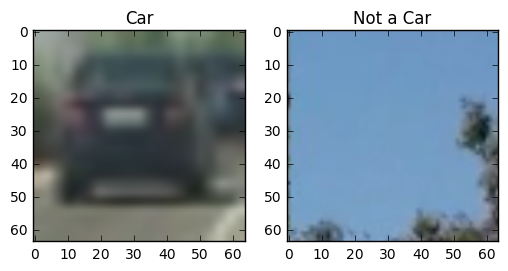

In [2]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

cars = glob.glob('vehicles/*/*.png', recursive=True)
notcars = glob.glob('non-vehicles/*/*.png', recursive=True)

print ("Number of car images: ", len(cars))
print ("Number of non-car images: ", len(notcars))

## Print some sample images
car_img = mpimg.imread(cars[0])
notcar_img = mpimg.imread(notcars[0])

fig = plt.figure()
a1=fig.add_subplot(1,2,1)
imgplot = plt.imshow(car_img)
a1.set_title('Car')
a2=fig.add_subplot(1,2,2)
imgplot = plt.imshow(notcar_img)
a2.set_title('Not a Car')

I used a combination of intuition and trial-and-error to pick the parameters for calculating HOG features. To develop an intuition for how the various parameters change the output I plotted the results on a random subsample of image data. 

In general, I found that the gradients in the RGB channel were  to be very informative, as the color channels caused the gradient information to be encoded in different channels depending on the color of the car. I had more luck with color spaces that transformed the image into a luma component (Y). I chose YCrCb because it is the most ubiquitous luma-chroma encoding scheme in use today. 

In [78]:
import cv2
import numpy as np

## FINAL PARAMETERS
########################################################################################
COLOR_SPACE = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENT = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 4 # HOG cells per block
HOG_CHANNEL = "ALL"
########################################################################################

def get_hog_images(image, 
                  color_space=COLOR_SPACE, 
                  orient=ORIENT, 
                  pix_per_cell=PIX_PER_CELL,
                  cell_per_block=CELL_PER_BLOCK):

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
        
    hog_images = []
    for hog_channel in range(feature_image.shape[-1]):
        features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                        orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        hog_images.append(hog_image)
    
    return feature_image, hog_images
    

I used the following code to visualize car images from the training data in their new color spaces, as well as the HOG features generated from those channels, to gain intuition as to which combination of features worked best. 

In YCrCb colorspace (and YUV as well), we can visualize how the information content drops off sharply after the first color channel. Initially, I only used the Y channel HOG features in the training data, but I found that using all 3 channeles still improved the test accuracy by ~1%; even though the Cr and Cb channeles among car and non-car images seem largely similar, they still contain important features. 

I did some manual trial-and-error to tweak the other parameters: pixels per cell, orient, and cells per block. The latter two had little effect on the model accuracy. Decreasing pixels per cell led to a slight decrease in test accuracy, while increasing it led to nearly identical performance. I kept `PIX_PER_CELL` at 8 to speed up training and help prevent overfitting. 

In [ ]:
import matplotlib.gridspec as gridspec

n_examples = 3

car_idx = np.random.choice(range(len(cars)), n_examples)
notcar_idx = np.random.choice(range(len(notcars)), n_examples)

gs1 = gridspec.GridSpec(n_examples*2, 7)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for j in range(n_examples):
    car_img = mpimg.imread(cars[car_idx[j]])
    ax0 = plt.subplot(gs1[2*j*7])
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    ax0.set_aspect('equal')
    plt.imshow(car_img)

    
    feature_image, hog_car_imgs = get_hog_images(car_img)
    for i in range(3):
        ax1 = plt.subplot(gs1[2*j*7+2*i+1])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(feature_image[:,:,i])
        
        ax2 = plt.subplot(gs1[2*j*7+2*i+2])
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_aspect('equal')
        plt.imshow(hog_car_imgs[i], cmap='gray')
        
    notcar_img = mpimg.imread(notcars[notcar_idx[j]])
    ax0 = plt.subplot(gs1[(2*j+1)*7])
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    ax0.set_aspect('equal')
    plt.imshow(notcar_img)
    
    feature_image, hog_car_imgs = get_hog_images(notcar_img)
    
    
    for i in range(3):
        ax3 = plt.subplot(gs1[(2*j+1)*7+2*i+1])
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])
        ax3.set_aspect('equal')
        plt.imshow(feature_image[:,:,i])
        
        ax4 = plt.subplot(gs1[(2*j+1)*7+2*i+2])
        ax4.set_xticklabels([])
        ax4.set_yticklabels([])
        ax4.set_aspect('equal')
        plt.imshow(hog_car_imgs[i], cmap='gray')
        
plt.savefig('hog_features.png')

There are other ways of describing our image data besides using HOG. The first is by computing a set of RGB color histograms for each image, such as following:

<img src="notebook_files/rgb-histogram-plot.jpg">

In [ ]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    


Finally, we use shrunken down versions of the raw image data (a technique we call here "spatial binning").

In [81]:

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

Given my HOG feature vectors, I found that the inclusion of these RGB features did improve the performance of my vehicle detection pipeline (~4 percentage points in test accuracy improvements in the classifier!).

For the new feature extraction techniques, we have two additional parameters for spatial binning size (the size of the shrunked down image), and number of bins in our color histogram.

I found that increasing the size of our spatial bins from 32 (the default in the calssroom module) to 48 gave the model extra power without overfitting, or blowing up the feature space. I suspect that this has to do with the fact that I discarded a lot of valuable spatial color information by using only luma in my HOG features. 

In [86]:
SPATIAL_SIZE = (48, 48) # Spatial binning dimensions
HIST_BINS = 32    # Number of histogram bins

### Classification using SVM

I use the `extract_features` function we defined in the classroom modules to generate a vector of HOG, spatial, and color features given a set of parameters. 

Here are all the hyperparameters I used, in one place:

In [139]:
## HOG
COLOR_SPACE = 'YCrCb' 
ORIENT = 9  
PIX_PER_CELL = 8
CELL_PER_BLOCK = 4 
HOG_CHANNEL = "ALL"

## SPATIAL BINNING
SPATIAL_SIZE = (32, 32)

## COLOR_HISTOGRAMS
HIST_BINS = 32 

## FEATURES TO USE
USE_HOG = True
USE_SPAT = True
USE_COL_HIST = True

In [140]:
import time

def convert_color(image, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            raise Exception("Unrecognized color space.")
    else: 
        feature_image = np.copy(image)      
    return feature_image

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
    return features


start = time.time()

car_features = extract_features(cars, color_space=COLOR_SPACE, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANNEL, spatial_feat=USE_SPAT, 
                        hist_feat=USE_COL_HIST, hog_feat=USE_HOG)

notcar_features = extract_features(notcars, color_space=COLOR_SPACE, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANNEL, spatial_feat=USE_SPAT, 
                        hist_feat=USE_COL_HIST, hog_feat=USE_HOG)

end = time.time()

print ("Feature extraction time: {0} seconds".format(round(end-start, 2)))

Feature extraction time: 81.62 seconds


Next, I trained a classifier on our car/non-car image data using two classifiers: linear support vector machine and a multi-layer perceptron.  

Since both classifiers produced accuracies > 90% using the default parameters, I did not do any hyperparameter optimization for this step of the pipelin. 

The default parameters for the Linear SVM include the following: 
- Regularization: L2 
- Objective function: Squared hinge loss

The default parameters fo the MLP include the following: 
- Hidden layers: 1
- Neurons in hidden layer: 100
- Activations: ReLU
The MLP is trained using stochastic gradient descent via the Adam optimizer. 


In [141]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import *
## Create matrix of training data 
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

## Training labels. 1: Car, 0: no car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', ORIENT,'orientations', PIX_PER_CELL,
    'pixels per cell and', CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))
print ("")

# Use a linear SVC and Multilayer perceptron
svc = LinearSVC()
mlp = MLPClassifier()

# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
print("")

## Check training time for MLP
t1=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train MLP...')
print("")

## Print out metrics of our model
y_pred = svc.predict(X_test)
print ("SVM CLASSIFIER METRICS:")
print('Test Accuracy of SVC = ', round(accuracy_score(y_pred, y_test), 4))
print('Test Precision of SVC = ', round(precision_score(y_pred, y_test), 4))
print('Test Recall of SVC = ', round(recall_score(y_pred, y_test), 4))
print("")

y_pred = mlp.predict(X_test)
print ("MULTILAYER PERCEPTRON METRICS:")
print('Test Accuracy of MLP = ', round(accuracy_score(y_pred, y_test), 4))
print('Test Precision of MLP = ', round(precision_score(y_pred, y_test), 4))
print('Test Recall of MLP = ', round(recall_score(y_pred, y_test), 4))

Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 13968

38.23 Seconds to train SVC...

98.79 Seconds to train MLP...

SVM CLASSIFIER METRICS:
Test Accuracy of SVC =  0.9907
Test Precision of SVC =  0.9909
Test Recall of SVC =  0.9903

MULTILAYER PERCEPTRON METRICS:
Test Accuracy of MLP =  0.9941
Test Precision of MLP =  0.9943
Test Recall of MLP =  0.9937


The primary purpose of printing out the metrics (accuracy, precision, recall) here was to try to improve the final video output. Given that our pipeline involves predicting on each 8x8 subsection over a 500x1000(ish) pixel graph, a one percentage point difference in these metrics actually means a noticeable change in the number of boxes being drawn on our camera image. 

Since evaluating our classifier on the final video output takes a long time, I used the classifier metrics as a benchmark in deciding which sets of hyperparameters to even bother testing on the final output video. 

Because the final step of our pipeline filters out false positives, I was willing to tolerate a slightly lower precision than recall metric (there is no backup mechanism if our classifier fails to identify a car). 


### Sliding Window Search

Now that we have a pretty robust image classifier for vehicle detection, we want to implement a sliding search mechanism to run our model over subsets of a larger image. 

To do this, I divide the larger image into 8x8 pixel cells, and a sliding window search that skips by 2 pixels (meaning two adjacent windows overlap by 75%). 

Since the HOG feature extraction step is computationally expensive, we precompute the gradients over the entire image before stepping through each subwindow.

Since the next step involves aggregating overlapping bounding boxes later, I didn't really spend any time tweaking the parameters for our cell/box size or step size. 

<img src="notebook_files/hog-sub.jpg">

The following function implements the steps of our vehicle detection pipeline so far:
- Image cropping and scaling (more on this later)
- Color space transformation
- HOG calculation
- Sliding window search
    - spatial binning (if applicable)
    - color histogram (if applicable)
    - classifier prediction 

In [142]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, hog_channel, color_space):
    boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            
            if spatial_feat:
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            if hog_feat:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                
                if hog_channel=="ALL":
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else: 
                    hog_features = [hog_feat1, hog_feat2, hog_feat3]
                    hog_features = hog_features[hog_channel]
                    
                features.append(hog_features)
                
            a = np.array(np.concatenate(features)).reshape(1, -1)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(a)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return draw_img, boxes

A few more parameters: we use `Y_START` and `Y_STOP` to define the latitudes of the image we're interested in; given that it's a fixed camera, no need to tune these here - I'll just use what's provided in the example. 

We also have a parameter called scale to shrink/magnify the subsections of our image before applying the classifier. A larger scale, a.k.a. magnification, will decrease the number of bounding boxes, and vice versa with a smaller scale. A smaller scale also significantly increases the time it takes to process a single frame, so I picked a scale that would be able to pick as many boxes as possible without sacrificing significant performance. 1.5 was the sweet spot. 

In [143]:
Y_START = 400
Y_STOP = 656
SCALE = 1.5

Let's see what these boxes look like.

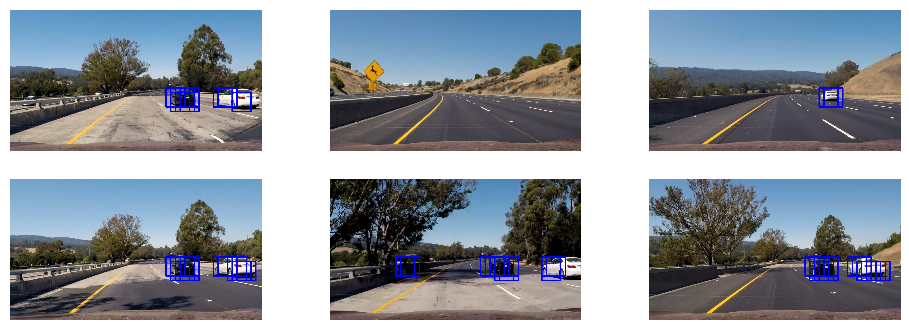

In [144]:
test_imgs = [mpimg.imread(jpg) for jpg in glob.glob('test_images/*.jpg', recursive=True)]

gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 
plt.figure(figsize=(12,4))
boxed_imgs = []
boxes = []
for i in range(6):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    output_img, box_coord = find_cars(test_imgs[i], Y_START, Y_STOP, SCALE, mlp, X_scaler, 
                           ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, HIST_BINS,
                           spatial_feat=USE_SPAT, hist_feat=USE_COL_HIST, hog_feat=USE_HOG, 
                           hog_channel=HOG_CHANNEL, color_space = COLOR_SPACE)
    plt.imshow(output_img, cmap='gray')
    boxes.append(box_coord)
    boxed_imgs.append(output_img)
    plt.axis('off')
    
    mpimg.imsave("output_images/raw_boxes_{0}.png".format(i), output_img)

### Boundary Box Post-Processing

Not bad. In the final part of the image processing pipeline, we want to aggregate overlapping bounding boxes, combine predictions from previous frames, and use this information to remove false positives to the best of our ability. 

To do this, I create a heatmap from the overlapping bounding boxes, filter out highlighted areas below a certain threshold, and then convert the heatmap back to a single bounding box. The `THRESHOLD` parameter is the cutoff (inclusive) for false positives. 

In [145]:
THRESHOLD = 1

In [146]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def remove_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


Here is the heatmap process at work on individual frames, from left to right:

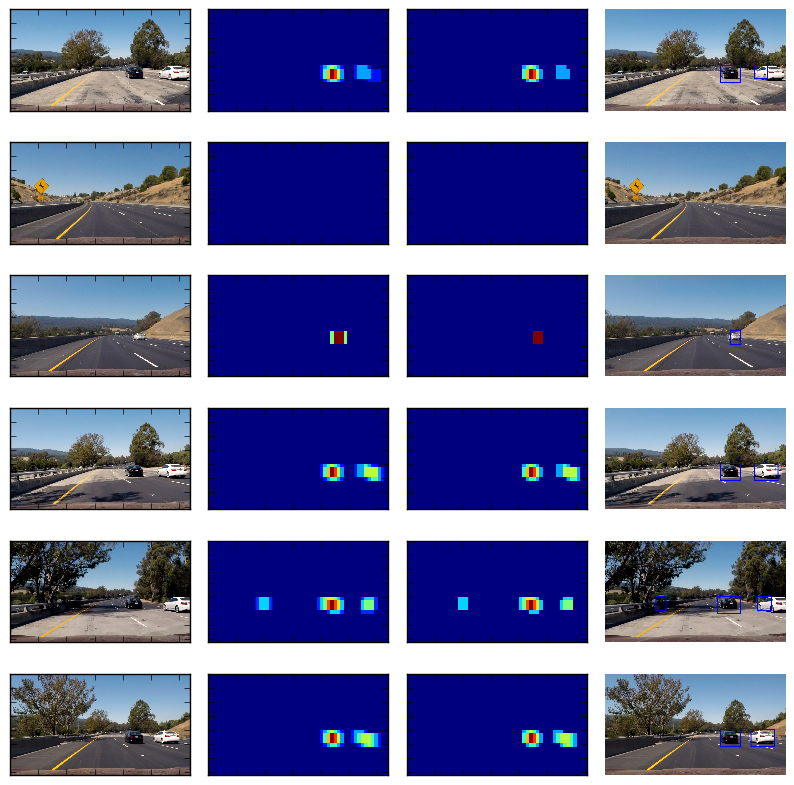

In [147]:
gs1 = gridspec.GridSpec(len(boxed_imgs), 4)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 
plt.figure(figsize=(10,10))
for i in range(len(boxed_imgs)):
    ax0 = plt.subplot(gs1[i*4])
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    plt.imshow(test_imgs[i])
    
    ax1 = plt.subplot(gs1[i*4+1])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    heat = np.zeros_like(boxed_imgs[i][:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes[i])
    
    plt.imshow(np.clip(heat, 0, 255))
    
    ax2 = plt.subplot(gs1[i*4+2])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,THRESHOLD)
    heatmap = np.clip(heat, 0, 255)
    plt.imshow(heatmap)
    
    ax3 = plt.subplot(gs1[i*4+3])
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(test_imgs[i], labels)
    plt.imshow(draw_img)
    mpimg.imsave("output_images/processed_boxes_{0}.png".format(i), draw_img)
    plt.axis('off')

Below is the code I used to generate the consecutive image frames from the test video. I next test my pipeline on the video frames to watch the heatmap aggregation and filtering process at work. 

In [148]:
# vidcap = cv2.VideoCapture('test_video.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# while success:
#     success,image = vidcap.read()
#     cv2.imwrite("vid_images/frame%03d.jpg" % count, image)
#     count += 1

vid_imgs = [mpimg.imread(i) for i in glob.glob('vid_images/*.jpg', recursive=True)][15:]

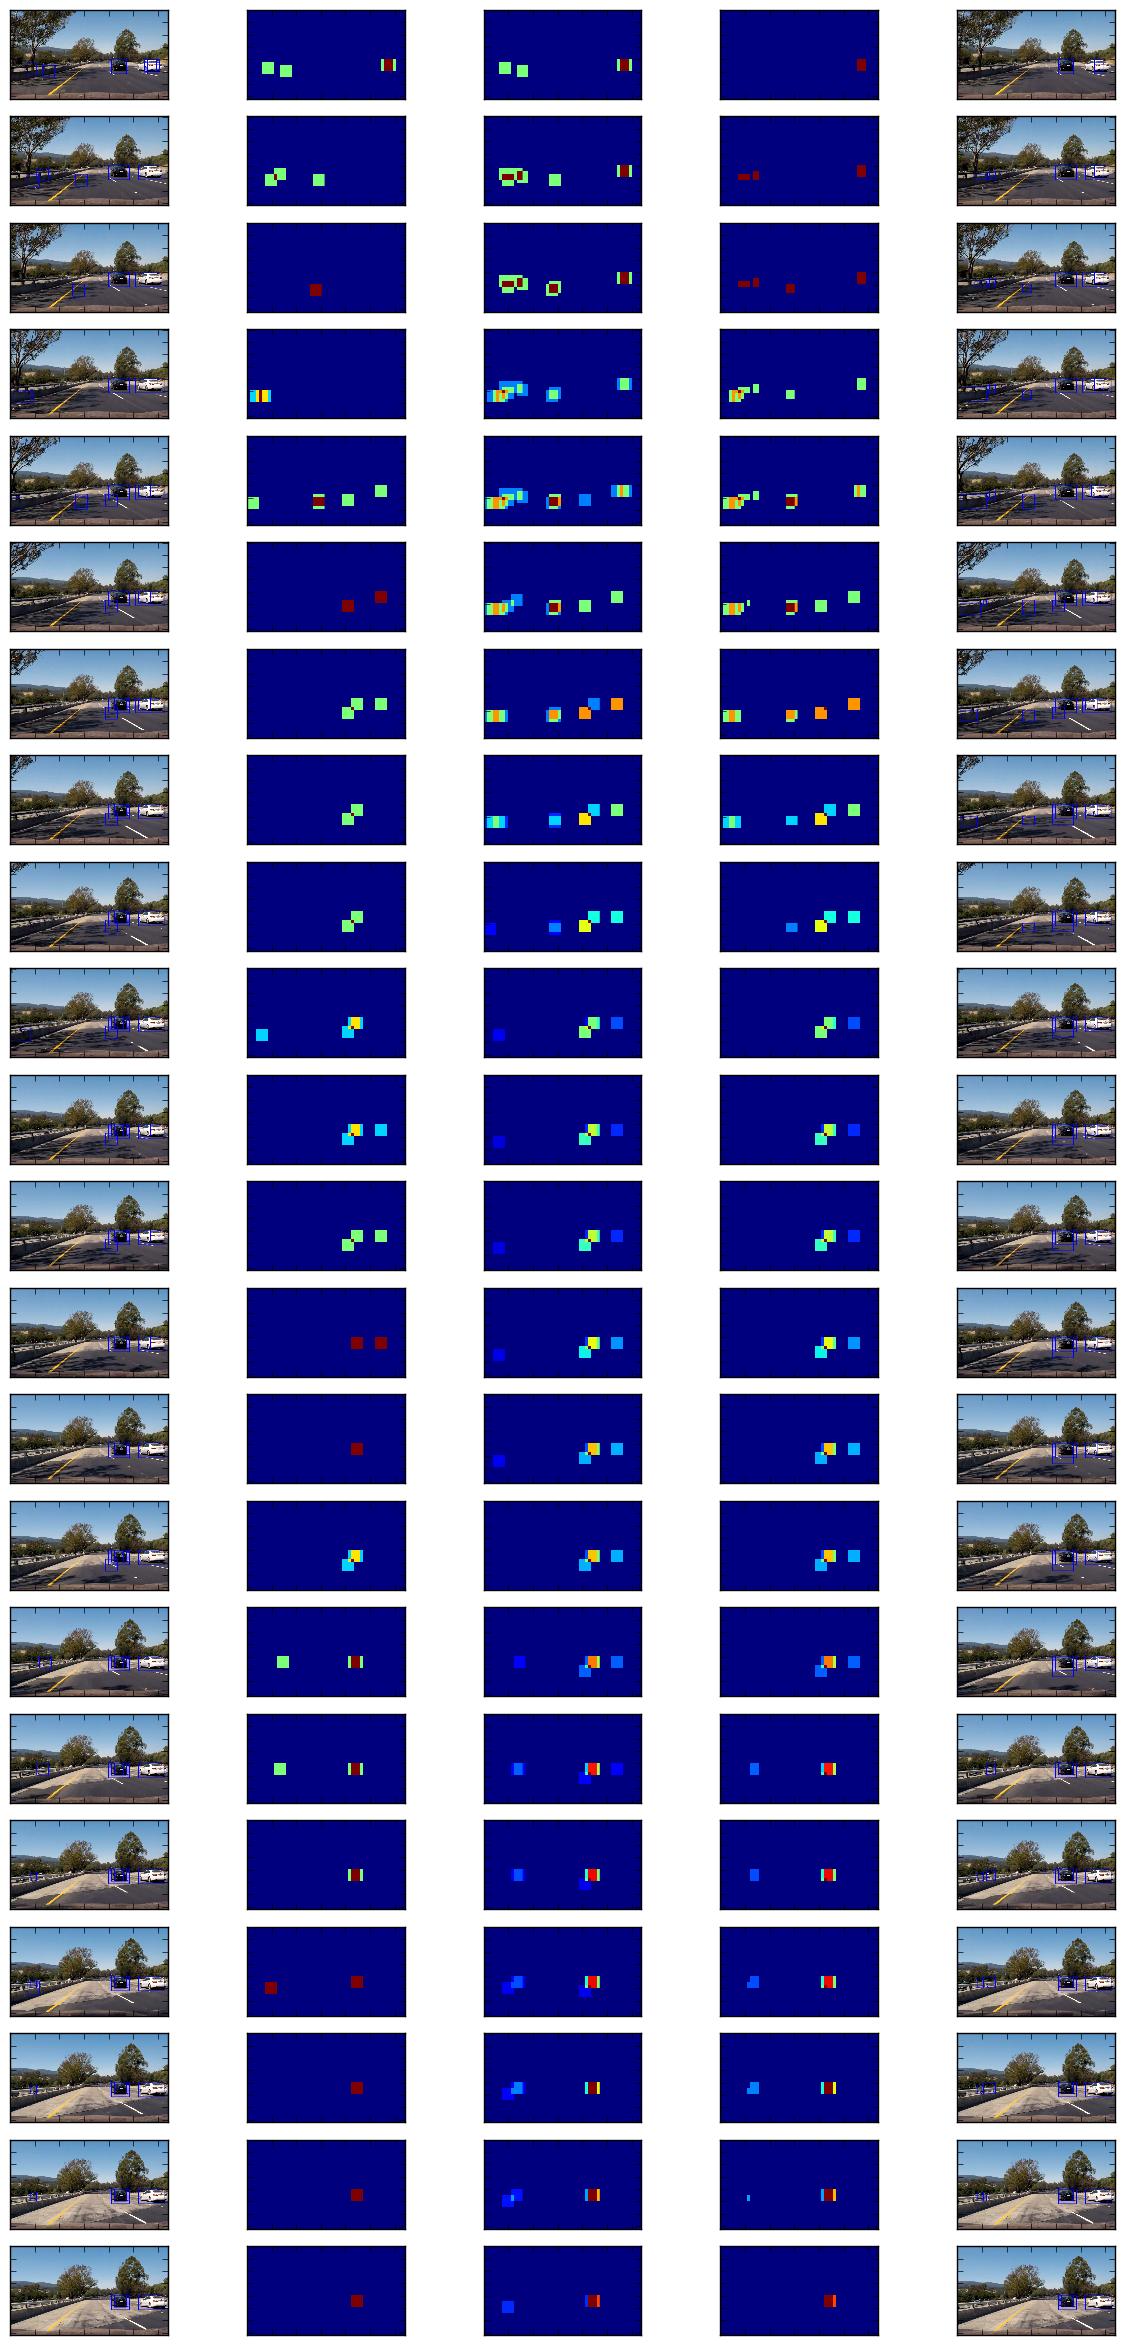

In [150]:
heatmap = None
heatarray = []

gs1 = gridspec.GridSpec(len(vid_imgs), 5)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 
plt.figure(figsize=(15,30))
for i in range(len(vid_imgs)):
    image = vid_imgs[i]
    output_img, box_coord = find_cars(image, Y_START, Y_STOP, SCALE, svc, X_scaler, 
                               ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, HIST_BINS,
                                True, True, True, 
                                HOG_CHANNEL, COLOR_SPACE)
    
    ax0 = plt.subplot(gs1[i*5])
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    plt.imshow(output_img)
    
    heat = np.zeros_like(output_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_coord)
    
    ax1 = plt.subplot(gs1[i*5+1])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(np.clip(heat, 0, 255))

    #if heatmap is None:
    #    heatmap = heat
    #else:
    #    heatmap = np.add(heatmap, heat)
    
    heatarray.append(heat)
    #print (len(heatarray))
    if len(heatarray) > 5:
        #heatmap = np.subtract(heatmap, heatarray[0])
        del heatarray[0]
    
    heatmap = np.zeros_like(output_img[:,:,0]).astype(np.float)
    for h in heatarray:
        heatmap = np.add(heatmap, h)
    
    heatmap = np.clip(heatmap, 0, 255)
    
    ax2 = plt.subplot(gs1[i*5+2])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    plt.imshow(heatmap)
    
    filtered_heatmap = apply_threshold(heatmap, THRESHOLD)
    
    ax3 = plt.subplot(gs1[i*5+3])
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    plt.imshow(np.clip(filtered_heatmap, 0, 255))
    
    labels = label(filtered_heatmap)
    final_img = draw_labeled_bboxes(image, labels)
    
    ax4 = plt.subplot(gs1[i*5+4])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    plt.imshow(final_img)
    

Finally, we create a `FrameProcessor` object to retain information from previous frames, and then combine all the components of our vehicle detection pipeline into a single function and apply it to a video input. 

The last addition to our pipeline here is to add up the heatmaps of the last N frames, and adjust our thresholding function accordingly.

In [152]:

class FrameProcessor(object):
    
    def __init__(self, y_start, y_stop, scale, classifier, x_scaler,
                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                spatial_features, hist_features, hog_features, hog_channel, hog_cspace, 
                 memory, threshold):
        
        ## Parameters
        self.y_start = y_start
        self.y_stop = y_stop
        self.scale = scale
        self.classifier = classifier
        self.x_scaler = x_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_features = spatial_features
        self.hist_features = hist_features
        self.hog_features = hog_features
        self.hog_channel = hog_channel
        self.hog_cspace = hog_cspace
        
        self.heatarray = []
        self.memory = memory
        self.threshold = threshold
        self.heatmap = None

    def process_image(self, image):   
        output_img, box_coord = find_cars(image, self.y_start, self.y_stop, self.scale, self.classifier, self.x_scaler, 
                               self.orient, self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins,
                               self.spatial_features, self.hist_features, self.hog_features, 
                               self.hog_channel, self.hog_cspace)

        heat = np.zeros_like(output_img[:,:,0]).astype(np.float)
        heat = add_heat(heat,box_coord)
        
        self.heatarray.append(heat)
        
        if len(self.heatarray) > self.memory:
            del self.heatarray[0]

        heatmap = np.zeros_like(output_img[:,:,0]).astype(np.float)
        for h in self.heatarray:
            heatmap = np.add(heatmap, h)
        
        heatmap = np.clip(heatmap, 0, 255)
        
        heatmap = apply_threshold(heatmap, self.threshold)
        labels = label(heatmap)
        final_img = draw_labeled_bboxes(image, labels)

        return final_img

    


For the last stage of the pipeline, I chose to add the last 10 frames and threshold all regions with less than 6 detections. I found that was able to filter out the most false positives without also significantly affecting the true positive count.  

Finally, I chose to use the MLP classifier over the linear SVM due to its (slightly) higher performance on our test data from earlier.

In [153]:
frameProcessor = FrameProcessor(Y_START, Y_STOP, SCALE, mlp, X_scaler, 
                               ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, HIST_BINS,
                                True, True, True, 
                                HOG_CHANNEL, COLOR_SPACE, memory=10, threshold=6)

In [154]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(frameProcessor.process_image) 
clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [15:23<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Discussion and Closing Thoughts

This video detection pipeline works well, but it's far from perfect. Some general thoughts from my many trial-and-error attempts:

- Faraway vehicles and extremely close-up vehicles aren't always labeled. If I had more time, I'd upsample these images in the training data.

- Ensembling seems to have some potential here. While YCrCb worked the best, some of the other color spaces I tried had their moments. An ensemble prediction model would involved training multiple classifiers using different HOG feature vectors, predict using all of them, and aggregate using the same method as above, probably with a higher threshold. I think this would actually do quite well; the weaker performance on totally out-of-sample data suggests some degree of overfitting, which ensembling is meant to help rectify. The final step of the current pipelin, where we aggregate consecutive labels and filter out weaker signals, has a similar effect to ensembling, but it would still be interesting to see where this gets us.  

The biggest challenge of this project was the disconnect between classifier performance and actual video detection quality. A higher accuracy/precision/recall did not always translate into better video labels. The multiple sets of hyperparameters also added another layer of complexity to determining which direction to proceed.  

Being equipped with a mere CPU for this process made re-training and video processing a very time-consuming process. Grid search over all the parameters was out of the question, and I had to rely on intuition and heuristics to narrow down the set of optimal parameters. 